In [1]:
!pwd
!which python
!python --version
!conda --version
!which conda

!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install biopython
!pip install umap-learn
!pip install --upgrade --no-cache-dir h5py
!pip install --upgrade fs.smbfs
!pip install -qqq roboflow supervision
!pip install plotly
!pip install seaborn==0.12.2

/data/nasif12/home_if12/arunkuma
/opt/modules/i12g/anaconda/envs/jupyterhub/bin/python
Python 3.8.13
conda 23.1.0
/opt/modules/i12g/anaconda/3-2019.10/condabin/conda
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/openai/CLIP.git to /scratch/tmp/arunkuma/pip-req-build-nmk_x3n9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /scratch/tmp/arunkuma/pip-req-build-nmk_x3n9
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import site
site.getsitepackages()

import sys
# make sure the conda libraries are recognized here
_ = sys.path.append("/opt/modules/i12g/anaconda/envs/jupyterhub/lib/python3.8/site-packages")

import os
HOME = os.getcwd()
print("HOME:", HOME)

import torch
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import clip
import csv
import re
from Bio import Entrez
import umap.umap_ as umap
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import plotly.graph_objects as go
import plotly.express as px

from typing import Dict
from pathlib import Path
from IPython.core.display import display, HTML
import base64
import supervision as sv
import cv2
from io import BytesIO
import matplotlib.colors as mcolors

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

HOME: /data/nasif12/home_if12/arunkuma


/opt/modules/i12g/anaconda/envs/jupyterhub/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/data/ouga/home/ag_gagneur/arunkuma/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/ouga/home/ag_gagneur/arunkuma/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is 

## Visualize an image of Zosteropidae

Here we picked some random bird to visualize the image.

In [3]:
# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

Image to be processed


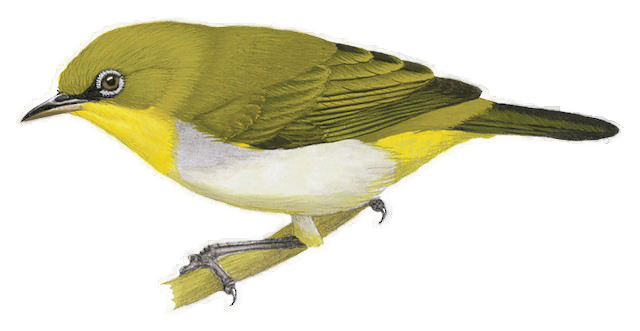



Tensor shape:
torch.Size([1, 3, 224, 224])


In [8]:
# Set up the image file path
image_path = '/s/project/gene2bird/image_data/BoW_plates/Zosteropidae/Yellow-throated_White-eye_Zosterops_metcalfii_153120981.png'

# Load the image
image = Image.open(image_path)
display(image)

# Pre-process the image
image = preprocess(image).unsqueeze(0).to(device)
print("\n\nTensor shape:")
print(image.shape)


In [9]:
# Image feature extraction
with torch.no_grad():
    image_features = model.encode_image(image)
print(image_features.shape)

torch.Size([1, 512])


## Extract genome data

Given our approx. 1k bird genomes we want to find to which species these genome files belong to and thus perform a species-genome-mapping here.

In [32]:
genome_dir = '/s/project/gene2bird/groupA/genome_assemblies_prot_fasta/ncbi-genomes-2023-05-31'
output_file = '/s/project/gene2bird/groupA/notebooks/species_genome_mapping.csv'

# Email address is required for accessing the NCBI database
Entrez.email = "mahima.arunkumar.1@gmail.com"

# Function to retrieve species name from assembly accession
def retrieve_species_name(contig):
    esearch_file = Entrez.esearch(db='assembly', term=contig)
    esearch_record = Entrez.read(esearch_file)
    es_handle = Entrez.esummary(db='assembly', id=id, report='full')
    es_record = Entrez.read(es_handle)
    result_final = es_record['DocumentSummarySet']['DocumentSummary'][0]['SpeciesName']
    return result_final
    


# Create a list to store the species and genome assembly mapping
species_genome_mapping = []

# Iterate over files in the genome directory
for root, dirs, files in os.walk(genome_dir):
    for file in files:
        # Match the file pattern
        match = re.search(r'(GCA_\d+\.\d+)', file)
        if match:
            genome_id = match.group(1)
            
            # Get the species name using the retrieve_species_name function
            species_name = retrieve_species_name(genome_id)
            
            # Append the species and genome assembly ID to the mapping list
            species_genome_mapping.append({'species': species_name, 'genome assembly ID': genome_id})
            
            # Print the result
            #print(f"Species: {species_name}, Genome ID: {genome_id}")

# Write the mapping to a CSV file
with open(output_file, 'w', newline='') as csv_file:
    fieldnames = ['species', 'genome assembly ID']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    
    writer.writeheader()
    writer.writerows(species_genome_mapping)

print(f"\nMapping saved to {output_file}")


Mapping saved to /s/project/gene2bird/groupA/species_genome_mapping.csv


## Run CLIP for all bird images

We want to run a pretrained CLIP model on all approx. 30k bird images to generate embeddings and save these emebeddings to file.

In [63]:
# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# Image directory
image_dir = '/s/project/gene2bird/image_data/BoW_plates/'

# List to store the embeddings and labels
embeddings = []
labels = []

# Iterate over the directories
for root, dirs, files in os.walk(image_dir):
    # Exclude hidden directories
    dirs[:] = [d for d in dirs if not d.startswith('.')]

    # Extract the family name from the directory path
    family_name = os.path.basename(root)
    print(family_name)
    
    # Iterate over the image files
    for file in files:
        # Image path
        image_path = os.path.join(root, file)

        # Preprocess the image
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)

        # Compute the embedding
        with torch.no_grad():
            embedding = model.encode_image(image)

        # Convert the embedding to numpy array and append to the list
        embeddings.append(embedding.cpu().numpy())
        
        # Use the family name as the label
        labels.append(family_name)

# Concatenate the embeddings and convert labels to a compatible dtype
embeddings = np.concatenate(embeddings, axis=0)
labels = np.array(labels, dtype=np.dtype('S'))


Falconidae
Corvidae
Picathartidae
Furnariidae
Rhynochetidae
Urocynchramidae
Neosittidae
Psittaculidae
Phaenicophilidae
Atrichornithidae
Monarchidae
Trogonidae
Nesospingidae
Rheidae
Cuculidae
Pelecanidae
Threskiornithidae
Chionidae
Upupidae
Indicatoridae
Sturnidae
Regulidae
Locustellidae
Pomatostomidae
Melanopareiidae
Cinclosomatidae
Petroicidae
Fringillidae
Sapayoidae
Teretistridae
Pycnonotidae
Bernieridae
Cacatuidae
Scotocercidae
Momotidae
Melampittidae
Grallariidae
Psophodidae
Callaeidae
Phoeniculidae
Heliornithidae
Ramphastidae
Hemiprocnidae
Sulidae
Dulidae
Icteriidae
Calyptophilidae
Modulatricidae
Spindalidae
Leptosomidae
Dasyornithidae
Zeledoniidae
Todidae
Climacteridae
Oreoicidae
Oceanitidae
Apodidae
Rallidae
Corcoracidae
Steatornithidae
Accipitridae
Apterygidae
Podargidae
Otididae
Cinclidae
Eupetidae
Stercorariidae
Irenidae
Thamnophilidae
Bucconidae
Eurypygidae
Phoenicopteridae
Rhinocryptidae
Anhimidae
Paramythiidae
Buphagidae
Procellariidae
Vireonidae
Zosteropidae
Strigidae
Sa

We have 249 different bird families.

In [65]:
# Save the embeddings and labels to an HDF5 file
with h5py.File('/s/project/gene2bird/groupA/notebooks/embeddings.h5', 'w') as f:
    f.create_dataset('embeddings', data=embeddings)
    f.create_dataset('labels', data=labels)

In [66]:
# Convert labels to a list of strings
labels_str = [label.decode('utf-8') for label in labels]

# Save the embeddings and labels as a CSV file
with open('/s/project/gene2bird/groupA/notebooks/embeddings.csv', 'w', newline='', encoding='utf-8') as f:
    np.savetxt(f, embeddings, delimiter=',')

with open('/s/project/gene2bird/groupA/notebooks/labels.csv', 'w', newline='', encoding='utf-8') as f:
    writer = csv.writer(f)
    writer.writerow(labels_str)

In [16]:
# Read in the embeddings
with h5py.File('/s/project/gene2bird/groupA/notebooks/embeddings.h5', 'r') as f:
    embeddings = f['embeddings'][:]
    
embeddings

array([[ 0.2314  ,  0.3157  , -0.3765  , ...,  0.4907  ,  0.003841,
        -0.563   ],
       [ 0.3057  ,  0.1797  , -0.4448  , ...,  0.3416  , -0.0328  ,
        -0.4343  ],
       [-0.02272 , -0.01169 ,  0.06964 , ...,  0.443   , -0.3318  ,
        -0.6934  ],
       ...,
       [ 0.8145  ,  0.3806  , -0.2281  , ...,  0.534   , -0.05716 ,
        -0.4243  ],
       [ 0.6987  ,  0.1923  , -0.2627  , ...,  0.4946  ,  0.008606,
        -0.4854  ],
       [ 0.6133  ,  0.4226  , -0.02994 , ...,  0.4688  , -0.01511 ,
        -0.703   ]], dtype=float16)

In [18]:
# Read the embeddings from the CSV file
embeddings = np.loadtxt('/s/project/gene2bird/groupA/notebooks/embeddings.csv', delimiter=',')

In [19]:
# Read the labels from the CSV file
with open('/s/project/gene2bird/groupA/notebooks/labels.csv', 'r', encoding='utf-8') as f:
    reader = csv.reader(f)
    labels = list(reader)[0]

# Print the shape of the embeddings and the first few labels
print("Shape of embeddings:", embeddings.shape)
print("Labels:", labels[:5])

Shape of embeddings: (22325, 512)
Labels: ['Falconidae', 'Falconidae', 'Falconidae', 'Falconidae', 'Falconidae']


## Visualize embeddings

We want to have a closer look at those embeddings.

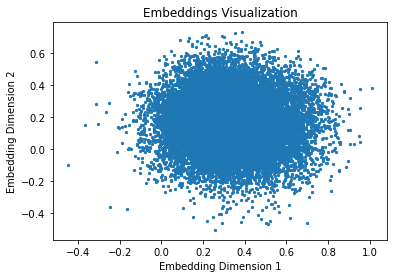

In [12]:
# Extract the X and Y coordinates from the embeddings
x = embeddings[:, 0]
y = embeddings[:, 1]

# Create a scatter plot of the embeddings
plt.scatter(x, y, s=5)
plt.xlabel('Embedding Dimension 1')
plt.ylabel('Embedding Dimension 2')
plt.title('Embeddings Visualization')
plt.show()

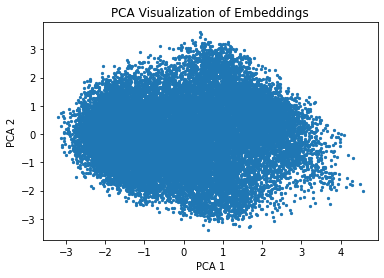

In [4]:
# Run PCA to reduce dimensionality
pca = PCA(n_components=2)
pca_emb = pca.fit_transform(embeddings)

# Plot the PCA visualization
plt.scatter(pca_emb[:, 0], pca_emb[:, 1], s=5)
plt.title('PCA Visualization of Embeddings')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

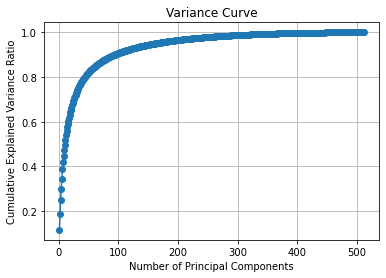

In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Run PCA to obtain the explained variance ratio
pca = PCA()
pca.fit(embeddings)

# Calculate the cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot the variance curve
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.title('Variance Curve')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

/data/ouga/home/ag_gagneur/arunkuma/.local/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


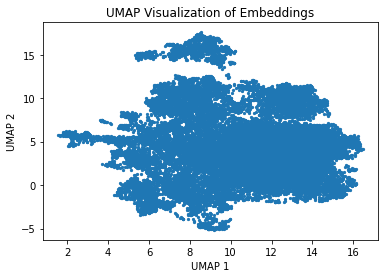

In [13]:
# Run UMAP to reduce dimensionality
umap_emb = umap.UMAP(n_neighbors=15, min_dist=0.5).fit_transform(embeddings)

# Plot the UMAP visualization
plt.scatter(umap_emb[:, 0], umap_emb[:, 1], s=5)
plt.title('UMAP Visualization of Embeddings')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

We note that overall there are not too many clusters.

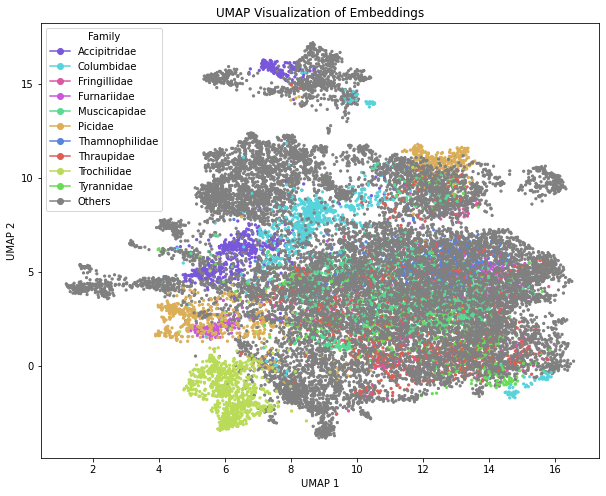

In [23]:
# Run UMAP to reduce dimensionality
umap_emb = umap.UMAP(n_neighbors=15, min_dist=0.5).fit_transform(embeddings)

# Determine the top 10 families
family_counts = np.unique(labels, return_counts=True)
sorted_indices = np.argsort(family_counts[1])[::-1]
top_10_families = family_counts[0][sorted_indices][:10]

# Generate a color palette with a limited number of distinct colors
num_colors = 10  # Number of distinct colors for top families
palette = sns.color_palette("hls", num_colors)

# Get unique families and assign a color to each family
unique_families = np.unique(labels)
family_colors = {}
for i, family in enumerate(unique_families):
    if family in top_10_families:
        family_colors[family] = palette[top_10_families.tolist().index(family)]
    else:
        family_colors[family] = 'grey'

# Prepare data for plotting
x = umap_emb[:, 0]
y = umap_emb[:, 1]
colors = [family_colors[family] for family in labels]

# Plot the UMAP visualization
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(x, y, s=5, c=colors)

ax.set_title('UMAP Visualization of Embeddings')
ax.set_xlabel('UMAP 1')
ax.set_ylabel('UMAP 2')

# Create a legend with colors for top 10 families and "Others" in grey
legend_elements = []
for family, color in family_colors.items():
    if family in top_10_families:
        legend_elements.append(plt.Line2D([0], [0], marker='o', color=color, label=family.decode('utf-8')))

# Add a legend element for "Others" in grey
legend_elements.append(plt.Line2D([0], [0], marker='o', color='grey', label='Others'))

ax.legend(handles=legend_elements, title='Family')

plt.show()

This plot uses UMAP to reduce dimensionality of the embeddings data where each point represents an embedding and the color of each point represents the family label associated with that embedding. 

It determines the top 10 families by counting the occurrences of each unique family label in the labels array. The families are sorted based on their frequency, and the top 10 families with the highest counts are selected. All other families have been grouped int "Others".

We see can definately see some clustering based on family.

In [6]:
projections = umap.UMAP(n_components=3, n_neighbors=15, min_dist=0.5).fit_transform(embeddings)

/data/ouga/home/ag_gagneur/arunkuma/.local/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


There are 249 different bird families and thus we have many different colors.

## Look at genome files

In [36]:
import gzip

cds_file = '/s/project/gene2bird/groupA/genome_assemblies_cds_fasta/ncbi-genomes-2023-05-31/GCA_013401375.1_ASM1340137v1_cds_from_genomic.fna.gz'

with gzip.open(cds_file, 'rt') as file:
    for line in file:
        if line.startswith('>'):
            gene_id = line.strip().split()[0][1:]
            #print(gene_id)

In [4]:
protein_file = '/s/project/gene2bird/groupA/genome_assemblies_prot_fasta/ncbi-genomes-2023-05-31/GCA_013401375.1_ASM1340137v1_protein.faa.gz'

with gzip.open(protein_file, 'rt') as file:
    for line in file:
        if line.startswith('>'):
            prot_id = line.strip().split()[0][1:]
            #print(prot_id)

## Heatmap to identify overlapping genes

In [6]:
import json

# List of JSON file paths
file_paths = [
    'first41_species.json',
    '42_to_115_species.json',
    '116_to_200_species.json',
    '201_to_end_species.json'
]
# Empty list to store the JSON data
json_data = []

# Iterate over each JSON file
for file_path in file_paths:
    # Open the file and load its contents
    with open(file_path, 'r') as file:
        data = json.load(file)
        # Append the loaded JSON data to the list
        json_data.append(data)

merged_data = {}
for data in json_data:
    merged_data.update(data)

# Write the merged data to a new JSON file if needed
output_path = '/s/project/gene2bird/groupA/notebooks/merged.json'
with open(output_path, 'w') as outfile:
    json.dump(merged_data, outfile)

In [17]:
with open("/s/project/gene2bird/groupA/notebooks/merged.json", "r") as file:
    gene_dat = json.load(file)
    for spec in gene_dat:
        #remove the species handle frome the gene name
        gene_dat[spec] = [g.split(",")[0] for g in gene_dat[spec]]
species = list(gene_dat.keys())
gen = []

#concatenate all genes into one long unique list
for gene in gene_dat:
    gen.extend(gene_dat[gene])
gen = np.unique(gen)

In [36]:
gen_df = pd.DataFrame(columns = species)

#fill up dataframe with species as columns, genes as rows and the presence/absence of a gene as value
for i, g in enumerate(gen):
    row = [g in gene_dat[s] for s in species]
    gen_df.loc[i] = row

gen_df.index = gen

In [37]:
# Save to file
gen_df.to_csv('/s/project/gene2bird/groupA/notebooks/gen_df.tsv', sep='\t', index=True)
gen_df.head()

,Leptocoma aspasia,Loxia leucoptera,Cochlearius cochlearius,Eolophus roseicapilla,Odontophorus gujanensis,Larus smithsonianus,Campylorhamphus procurvoides,Glareola pratincola,Chloroceryle aenea,Ibidorhyncha struthersii,...,Chloropsis cyanopogon,Scopus umbretta,Rhinopomastus cyanomelas,Pomatorhinus ruficollis,Balaeniceps rex,Passerina amoena,Hypocryptadius cinnamomeus,Horornis vulcanius,Cercotrichas coryphoeus,Asarcornis scutulata
104K protein,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
110KD protein,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1433B protein,True,True,True,True,False,True,True,True,True,False,...,True,True,True,True,False,True,False,True,True,True
1433E protein,True,True,False,True,True,False,True,True,True,False,...,True,False,True,True,False,True,True,True,True,True
1433F protein,True,True,True,True,False,False,True,True,True,False,...,True,True,True,True,False,True,True,True,True,True


In [4]:
gen_df = pd.read_csv('/s/project/gene2bird/groupA/notebooks/gen_df.tsv', sep='\t', index_col=0)

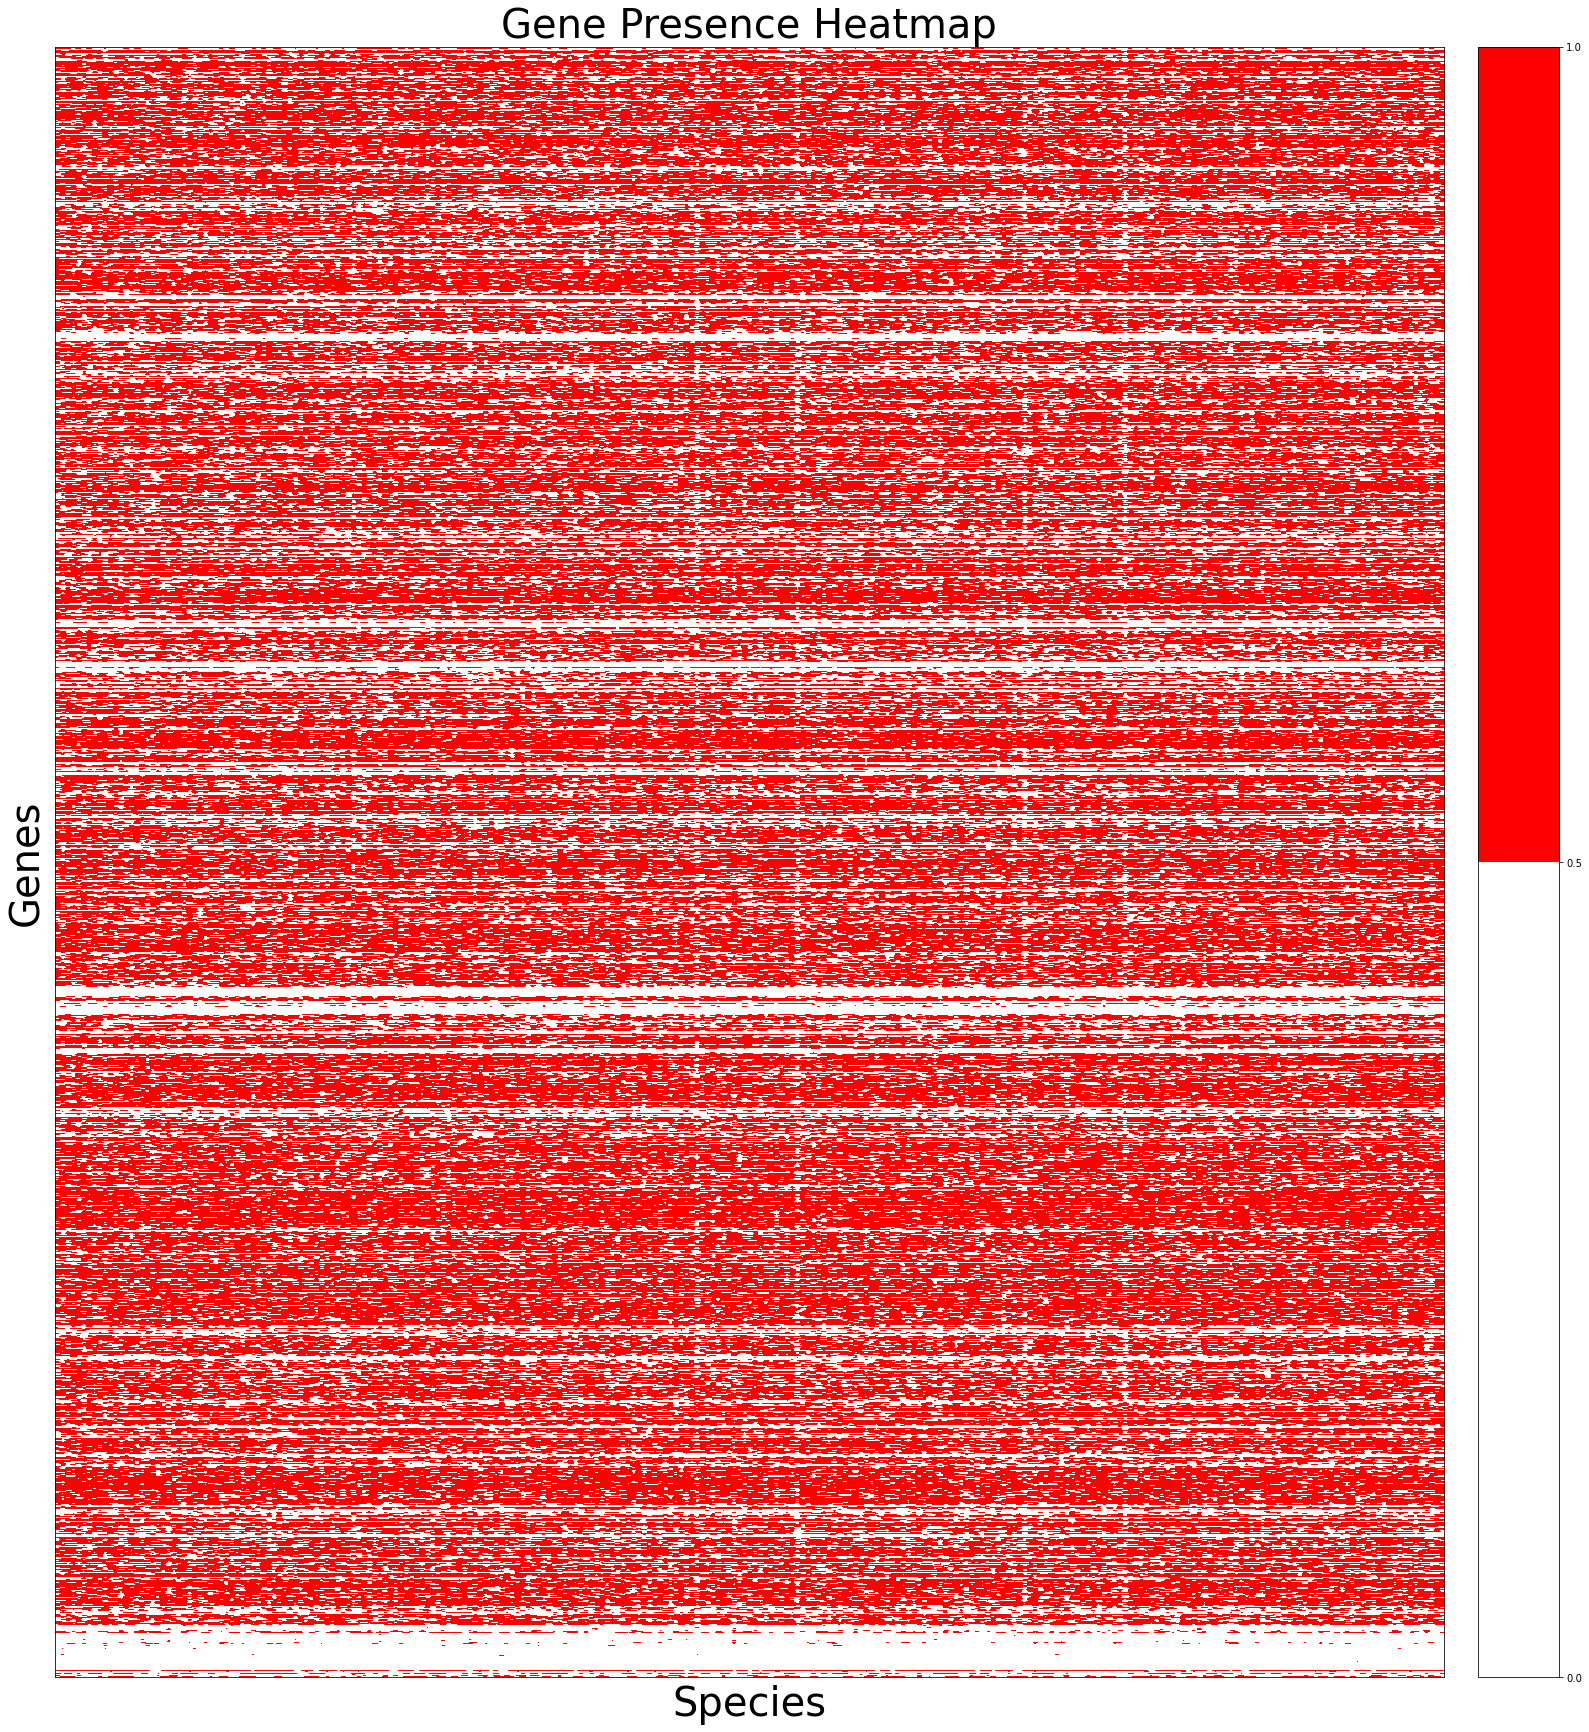

In [10]:
# Set the figure size
fig, ax = plt.subplots(figsize=(30, 30))

# Create a custom colormap with two colors
custom_cmap = mcolors.ListedColormap(['white', 'red'])

# Set the boundaries for the colorbar levels
bounds = [0, 0.5, 1]  # Adjust the values based on your gene presence/absence data
norm = mcolors.BoundaryNorm(bounds, custom_cmap.N)

# Plotting the heatmap with the custom colormap and norm
plt.imshow(gen_df, cmap=custom_cmap, norm=norm, aspect='auto')

# Set y-axis ticks and labels
plt.yticks([])
plt.ylabel("Genes", fontsize=40)

# Set x-axis ticks and labels
plt.xticks([])
plt.xlabel("Species", fontsize=40)

# Create a colorbar with discrete levels
cbar = plt.colorbar(ticks=bounds, boundaries=bounds, pad=0.02)

# Set the title
plt.title("Gene Presence Heatmap", fontsize=40)

# Display the plot
plt.show()

In [9]:
# Calculate the gene counts across species
gene_counts = gen_df.sum(axis=1)

# Find the genes that appear in all species
genes_in_all_species = gene_counts[gene_counts == gen_df.shape[1]].index.tolist()

# Find the outliers (genes that hardly appear in any species)
outlier_threshold = 1  
outlier_genes = gene_counts[gene_counts <= outlier_threshold].index.tolist()

# Print the genes that appear in all species
print("Number of gene appearing in all species: " + str(len(genes_in_all_species)))

# Print the outlier genes
print("Number of outlier genes: " + str(len(outlier_genes)))

# Print the remaining genes
remaining_genes = gen_df.index.difference(genes_in_all_species + outlier_genes)
print("Number of potential genes of interest: " + str(len(remaining_genes)))

Number of gene apearing in all species: 0
Number of outlier genes: 723
Number of potential genes of interest: 16336


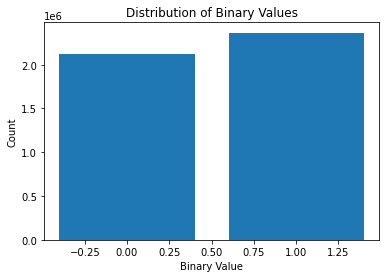

In [14]:
# Calculate the count of each binary value
value_counts = gen_df.stack().value_counts()

# Create a bar plot
plt.bar(value_counts.index, value_counts.values)

# Add labels and title
plt.xlabel('Binary Value')
plt.ylabel('Count')
plt.title('Distribution of Binary Values')

# Display the plot
plt.show()

## Using OpenAI CLIP embeddings to detect similar images by comparing the embeddings of different images

A common way to measure similarity between vectors is by calculating the cosine similarity. Normalization is an important step when computing cosine similarity because it makes the vectors unit length. This ensures that the cosine similarity only measures the angular distance between the vectors and not their magnitudes. Cosine similarity measures the angle between two vectors, and it's defined as the dot product of the vectors divided by the product of their magnitudes

In [6]:
def normalize(vec: np.ndarray):
    return vec / np.linalg.norm(vec, axis=1, keepdims=True)

In [8]:
normalized_embeddings = normalize(embeddings)
cosine_sim_matrix = np.dot(normalized_embeddings, normalized_embeddings.T)
cosine_sim_matrix

array([[1.        , 0.95183826, 0.82265044, ..., 0.92306164, 0.89849425,
        0.87427598],
       [0.95183826, 1.        , 0.81603718, ..., 0.90766041, 0.88836584,
        0.84805552],
       [0.82265044, 0.81603718, 1.        , ..., 0.83737048, 0.86688396,
        0.8563581 ],
       ...,
       [0.92306164, 0.90766041, 0.83737048, ..., 1.        , 0.96909505,
        0.9445407 ],
       [0.89849425, 0.88836584, 0.86688396, ..., 0.96909505, 1.        ,
        0.95426945],
       [0.87427598, 0.84805552, 0.8563581 , ..., 0.9445407 , 0.95426945,
        1.        ]])

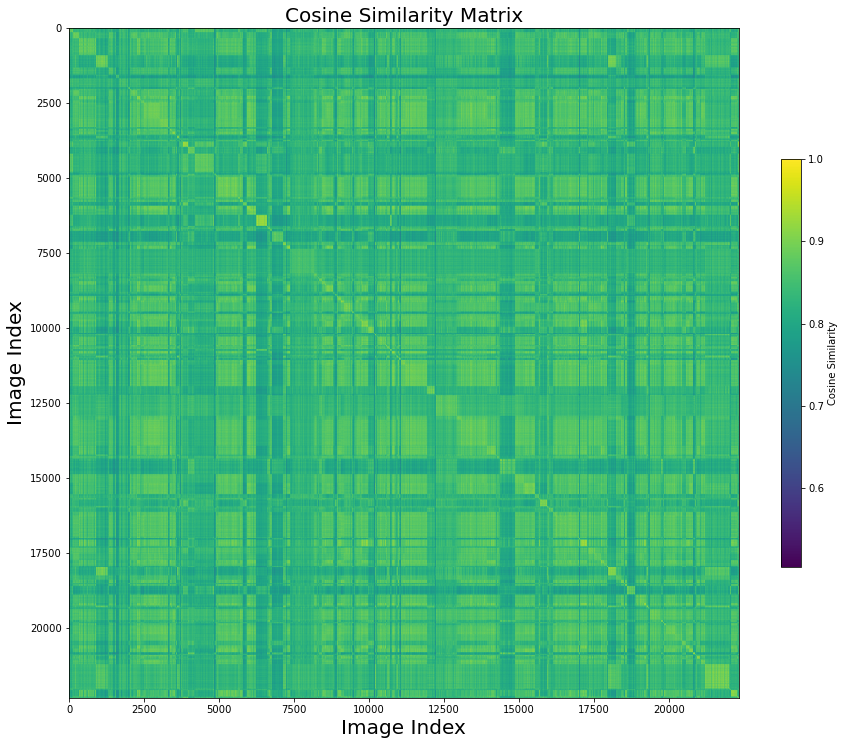

In [70]:
# 2D heatmap for entire cosine similarity matrix

plt.figure(figsize=(15, 15))
plt.imshow(cosine_sim_matrix, cmap='viridis')
plt.colorbar(label='Cosine Similarity', shrink=0.5)
plt.title('Cosine Similarity Matrix', fontsize = 20)
plt.xlabel('Image Index', fontsize = 20)
plt.ylabel('Image Index', fontsize = 20)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

We can see some birds seem to have higher similarity than others but overall all birds do not seem to dissimilar.

In [1]:
# Define the range of images you are interested in -> the whole cosine matrix takes too long and crashes the kernal, therefore we have to subset the image index range


"""start_index = 1000
end_index = 2500

# Slice the cosine similarity matrix for the desired range
sliced_matrix = cosine_sim_matrix[start_index:end_index, start_index:end_index]

# Create the heatmap plot
fig = go.Figure(data=go.Heatmap(z=sliced_matrix, colorscale='Viridis'))

# Customize the layout
fig.update_layout(
    title="Cosine Similarity Matrix (Image Range: {}-{})".format(start_index, end_index),
    xaxis_title="Image Index",
    yaxis_title="Image Index",
    font=dict(size=14),
    width=1000,
    height=1000,
    margin=dict(t=100, r=100, b=100, l=100),
)

# Display the heatmap
fig.show()"""


'start_index = 1000\nend_index = 2500\n\n# Slice the cosine similarity matrix for the desired range\nsliced_matrix = cosine_sim_matrix[start_index:end_index, start_index:end_index]\n\n# Create the heatmap plot\nfig = go.Figure(data=go.Heatmap(z=sliced_matrix, colorscale=\'Viridis\'))\n\n# Customize the layout\nfig.update_layout(\n    title="Cosine Similarity Matrix (Image Range: {}-{})".format(start_index, end_index),\n    xaxis_title="Image Index",\n    yaxis_title="Image Index",\n    font=dict(size=14),\n    width=1000,\n    height=1000,\n    margin=dict(t=100, r=100, b=100, l=100),\n)\n\n# Display the heatmap\nfig.show()'

This second cosine similarity heatmap is based on plotly and can bee zoomed in to inspect smaller image ranges of interest in more detail.

## Find similar birds based on cosine similarity

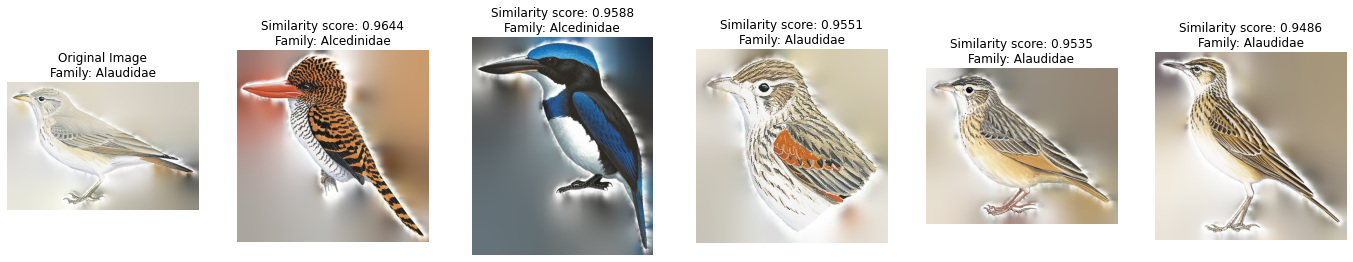

In [27]:
IMAGE_INDEX = 1000  # set bird with image index of interest
SIMILAR_IMAGE_COUNT = 5  # set how many similar birds you want to see

def get_n_most_similar_images(
    cosine_sim_matrix: np.ndarray, 
    image_index: int, 
    similar_image_count: int
) -> np.ndarray:
    similarities = cosine_sim_matrix[image_index]
    sorted_indices = np.argsort(similarities)[::-1]
    return sorted_indices[1:similar_image_count+1]

def preprocess_image_data(image_data: str) -> np.ndarray:
    image_data = base64.b64decode(image_data.split(",")[-1])
    image = Image.open(BytesIO(image_data))
    image_array = np.array(image)
    return cv2.cvtColor(image_array, cv2.COLOR_RGB2BGR)

# Get the indices of the most similar images
most_similar_indices = get_n_most_similar_images(
    cosine_sim_matrix=cosine_sim_matrix, 
    image_index=IMAGE_INDEX, 
    similar_image_count=SIMILAR_IMAGE_COUNT
)
most_similar_cosine_values = cosine_sim_matrix[IMAGE_INDEX, most_similar_indices]

image_path = image_paths[IMAGE_INDEX]
image_data = image_data_uris[image_path]
image_array = preprocess_image_data(image_data=image_data)

image_arrays = [image_array]
image_titles = [f"Original Image\nFamily: {labels[IMAGE_INDEX]}"]

# Iterate over the most similar indices and add the respective images
for image_index, similarity_score in zip(most_similar_indices, most_similar_cosine_values):
    image_path = image_paths[image_index]
    image_data = image_data_uris[image_path]
    image_array = preprocess_image_data(image_data=image_data)
    image_arrays.append(image_array)
    family_label = labels[image_index]  # Assuming labels is the array of bird family labels
    image_titles.append(f"Similarity score: {similarity_score:.4f}\nFamily: {family_label}")

image_count = len(image_arrays)
sv.plot_images_grid(
    images=image_arrays, 
    titles=image_titles, 
    grid_size=(1, image_count), 
    size=(4 * image_count, 4))

This allows us to visually inspect the most similar birds based on cosine similarity regarding our bird of interest. This may be helpful in understanding why certain classifiers tend to misclassify certain groups as well.

For this example we can see that cosine similarity does a pretty good job in finding birds belonging to the same family but we also see that it is not perfect.